In [ ]:
import numpy as np
from scipy.linalg import sqrtm
from scipy.stats import kendalltau
from scipy.stats import pearsonr
from scipy.stats  import spearmanr
from numpy.linalg import norm
from scipy.stats import wishart
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf
from sklearn.covariance import OAS



In [ ]:
## functions
def kl(sigma_true, sigma_est):
    d = sigma_true.shape[0]
    inv_sigma_est = np.linalg.inv(sigma_est)
    trace_term = np.trace(inv_sigma_est @ sigma_true)
    log_det_term = np.log(np.linalg.det(sigma_est) / np.linalg.det(sigma_true))
    return (trace_term - d + log_det_term)

def symkl(sigma_true, sigma_est):
    d = sigma_true.shape[0]
    sqrtinvest = sqrtm(np.linalg.inv(sigma_est))
    Q = sqrtinvest @ sigma_true @ sqrtinvest.T
    return (np.trace(Q) + np.trace(np.linalg.inv(Q)) - 2*d)

def mseq(sigma_true, sigma_est):
    d = sigma_true.shape[0]
    sqrtinvest = sqrtm(np.linalg.inv(sigma_est))
    Q = sqrtinvest @ sigma_true @ sqrtinvest.T
    return norm(Q - np.eye(d), 'fro')

def nsnr(sigma_true, sigma_est):
    sqrtinvest = sqrtm(np.linalg.inv(sigma_est))
    Q = sqrtinvest @ sigma_true @ sqrtinvest.T
    eigQ = np.linalg.eigh(Q)[0]
    qmax = np.max(eigQ)
    qmin = np.min(eigQ)
    cond = qmax/qmin + 1e-6
    return np.log((cond+1)**2/4/cond)



In [ ]:
## table 1

np.random.seed(1)
d = 10

sigma_true = np.eye(d)
sqrt_sigma_true = sqrtm(sigma_true)


n_list = np.arange(50,201,50)
num_n = len(n_list)
num_experiments = 1000
frob_errors = np.zeros((num_experiments,num_n))
mseq_errors = np.zeros((num_experiments,num_n))
op_errors = np.zeros((num_experiments,num_n))
kl_errors = np.zeros((num_experiments,num_n))
symkl_errors = np.zeros((num_experiments,num_n))
nsnr_errors = np.zeros((num_experiments,num_n))

pr_frob = np.zeros((num_n))
pr_mseq = np.zeros((num_n))
pr_kl = np.zeros((num_n))
pr_symkl = np.zeros((num_n))
pr_op = np.zeros((num_n))
for j in range(num_n):
  n = n_list[j]
  for i in range(num_experiments):
      samples = np.random.multivariate_normal(np.zeros(d), sigma_true, n)
      sigma_est = np.cov(samples, rowvar=False)

      # Compute the errors
      frob_errors[i,j] = norm(sigma_true - sigma_est, 'fro')
      op_errors[i,j] = norm(sigma_est - sigma_true, 2)
      kl_errors[i,j] = kl(sigma_true, sigma_est)
      symkl_errors[i,j] = symkl(sigma_true, sigma_est)
      nsnr_errors[i,j] = nsnr(sigma_true, sigma_est)

  # Calculate correlations of different metrics with respect to nsnr
  corr = pearsonr
  pr_frob[j], _ = corr(frob_errors[:,j], nsnr_errors[:,j])
  pr_mseq[j], _ = corr(mseq_errors[:,j], nsnr_errors[:,j])
  pr_kl[j], _ = corr(kl_errors[:,j], nsnr_errors[:,j])
  pr_symkl[j], _ = corr(symkl_errors[:,j], nsnr_errors[:,j])
  pr_op[j], _ = corr(op_errors[:,j], nsnr_errors[:,j])

# Print results
print(f"Frobenius:        {np.round(pr_frob,2)}")
print(f"KL divergence:    {np.round(pr_kl,2)}")
print(f"symKL divergence: {np.round(pr_symkl,2)}")
print(f"Operator Norm:    {np.round(pr_op,2)}")


<ipython-input-14-9edee428cbab>:41: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pr_mseq[j], _ = corr(mseq_errors[:,j], nsnr_errors[:,j])


N:                [ 50 100 150 200]
Frobenius:        [0.61 0.7  0.78 0.77]
KL divergence:    [0.82 0.82 0.85 0.82]
symKL divergence: [0.85 0.85 0.87 0.85]
Operator Norm:    [0.48 0.58 0.66 0.65]


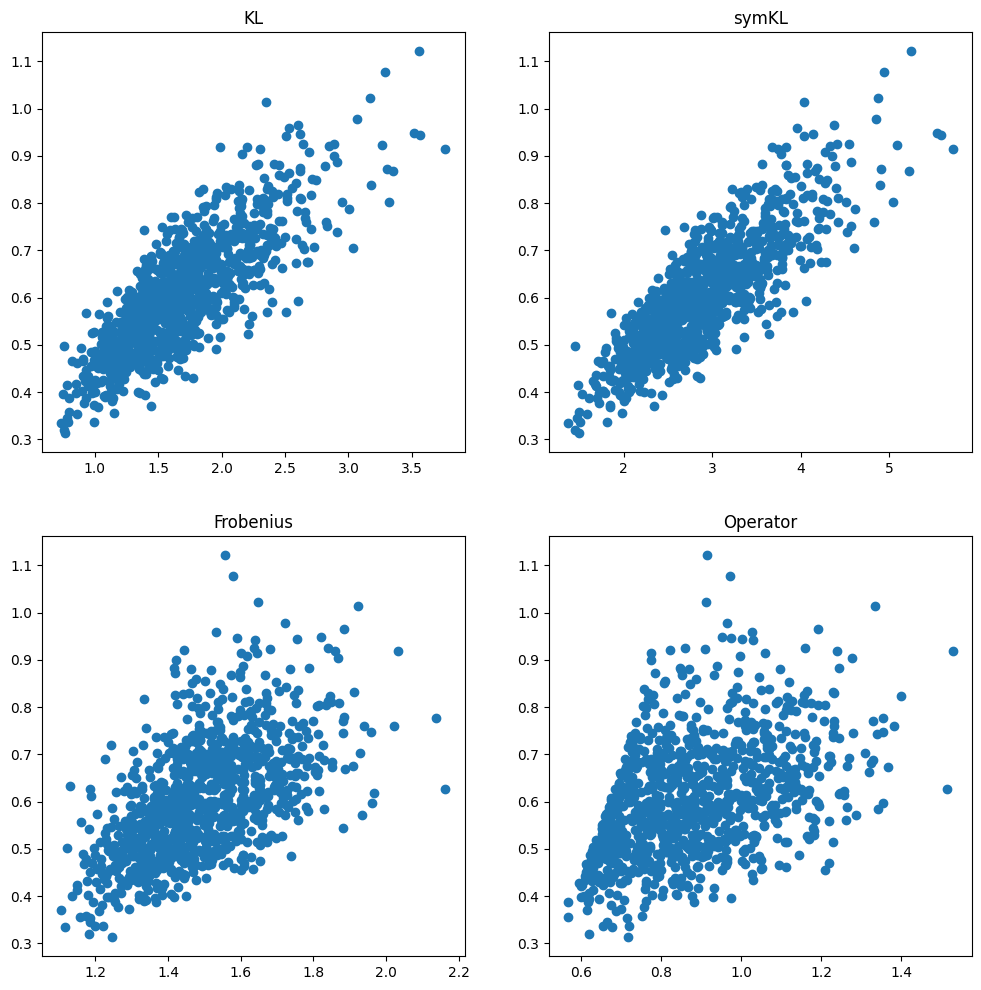

In [ ]:
## Figure 1


fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

ax0.scatter(kl_errors[:,0],nsnr_errors[:,0])
ax0.set_title("KL")

ax1.scatter(symkl_errors[:,0],nsnr_errors[:,0])
ax1.set_title("symKL")

ax2.scatter(frob_errors[:,0],nsnr_errors[:,0])
ax2.set_title("Frobenius")

ax3.scatter(op_errors[:,0],nsnr_errors[:,0])
ax3.set_title("Operator")
plt.show()

In [ ]:
## table 2

d = 10

sigma_true = np.eye(d)
sigma_true[0,0] = 100
sqrt_sigma_true = sqrtm(sigma_true)


n_list = np.arange(50,201,50)
num_n = len(n_list)
num_experiments = 1000
frob_errors = np.zeros((num_experiments,num_n))
mseq_errors = np.zeros((num_experiments,num_n))
op_errors = np.zeros((num_experiments,num_n))
kl_errors = np.zeros((num_experiments,num_n))
symkl_errors = np.zeros((num_experiments,num_n))
nsnr_errors = np.zeros((num_experiments,num_n))

pr_frob = np.zeros((num_n))
pr_mseq = np.zeros((num_n))
pr_kl = np.zeros((num_n))
pr_symkl = np.zeros((num_n))
pr_op = np.zeros((num_n))
for j in range(num_n):
  n = n_list[j]
  for i in range(num_experiments):
      samples = np.random.multivariate_normal(np.zeros(d), sigma_true, n)
      sigma_est = np.cov(samples, rowvar=False)

      # Compute the errors
      frob_errors[i,j] = norm(sigma_true - sigma_est, 'fro')
      op_errors[i,j] = norm(sigma_est - sigma_true, 2)
      kl_errors[i,j] = kl(sigma_true, sigma_est)
      symkl_errors[i,j] = symkl(sigma_true, sigma_est)
      nsnr_errors[i,j] = nsnr(sigma_true, sigma_est)

  # Calculate correlations of different metrics with respect to nsnr
  corr = pearsonr
  pr_frob[j], _ = corr(frob_errors[:,j], nsnr_errors[:,j])
  pr_mseq[j], _ = corr(mseq_errors[:,j], nsnr_errors[:,j])
  pr_kl[j], _ = corr(kl_errors[:,j], nsnr_errors[:,j])
  pr_symkl[j], _ = corr(symkl_errors[:,j], nsnr_errors[:,j])
  pr_op[j], _ = corr(op_errors[:,j], nsnr_errors[:,j])

# Print results
print(f"Frobenius:        {np.round(pr_frob,2)}")
print(f"KL divergence:    {np.round(pr_kl,2)}")
print(f"symKL divergence: {np.round(pr_symkl,2)}")
print(f"Operator Norm:    {np.round(pr_op,2)}")



<ipython-input-15-3ba0e0465114>:41: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pr_mseq[j], _ = corr(mseq_errors[:,j], nsnr_errors[:,j])


Frobenius:        [0.15 0.05 0.11 0.12]
KL divergence:    [0.83 0.83 0.84 0.83]
symKL divergence: [0.85 0.86 0.87 0.85]
Operator Norm:    [0.14 0.04 0.11 0.11]


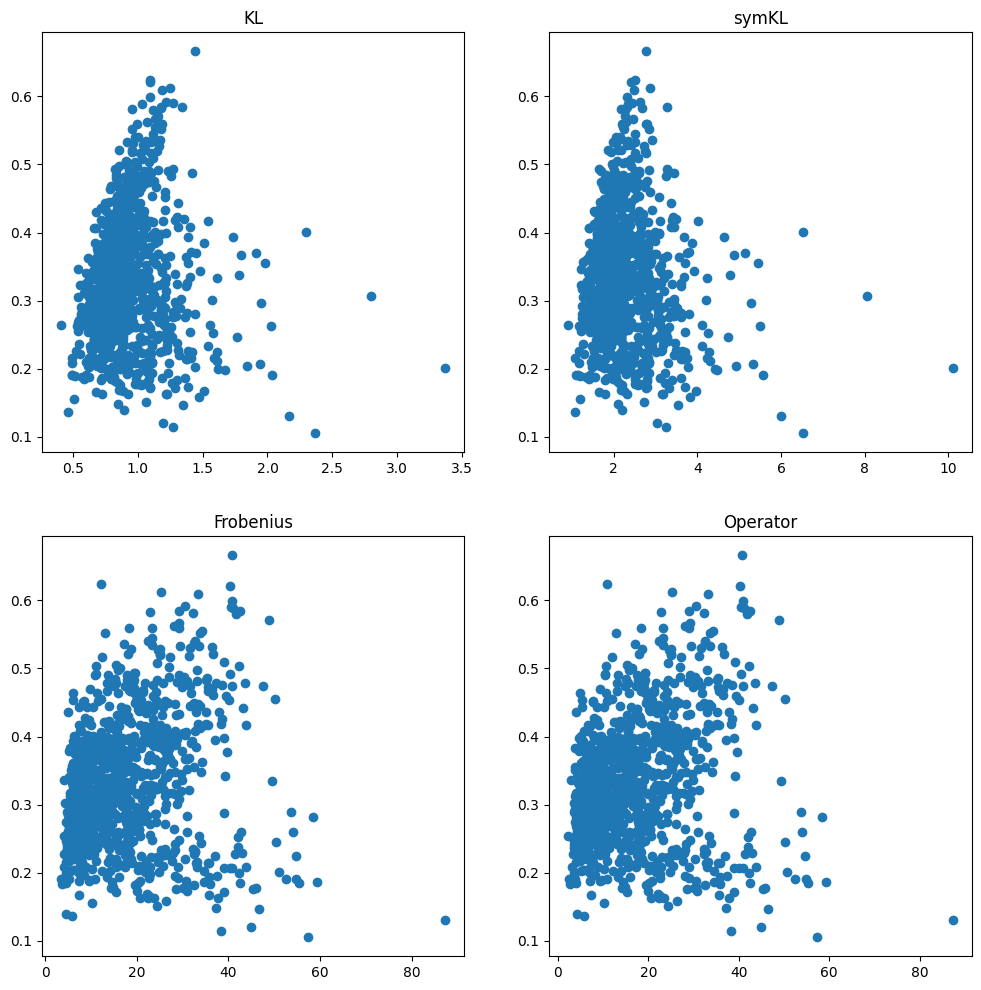

In [ ]:
## table 3


d = 10
sigma_true = np.eye(d)
sigma_true[0,0] = 100
sqrt_sigma_true = sqrtm(sigma_true)


n_list = np.array([0.01,0.1,-1])
num_n = len(n_list)
num_experiments = 1000
frob_errors = np.zeros((num_experiments,num_n))
mseq_errors = np.zeros((num_experiments,num_n))
op_errors = np.zeros((num_experiments,num_n))
kl_errors = np.zeros((num_experiments,num_n))
symkl_errors = np.zeros((num_experiments,num_n))
nsnr_errors = np.zeros((num_experiments,num_n))
pr_frob = np.zeros((num_n))
pr_mseq = np.zeros((num_n))
pr_kl = np.zeros((num_n))
pr_symkl = np.zeros((num_n))
pr_op = np.zeros((num_n))
for j in range(num_n):
  n = 200
  reg = n_list[j]
  for i in range(num_experiments):
      samples = np.random.multivariate_normal(np.zeros(d), sigma_true, n)
      if reg>0:
        sigma_est = np.cov(samples, rowvar=False) + reg * np.eye(d)
      else:
        sigma_est = LedoitWolf(assume_centered=True).fit(samples).covariance_

      # Compute the errors
      frob_errors[i,j] = norm(sigma_true - sigma_est, 'fro')
      mseq_errors[i,j] = mseq(sigma_true, sigma_est)
      op_errors[i,j] = norm(sigma_est - sigma_true, 2)
      kl_errors[i,j] = kl(sigma_true, sigma_est)
      symkl_errors[i,j] = symkl(sigma_true, sigma_est)
      nsnr_errors[i,j] = nsnr(sigma_true, sigma_est)

  # Calculate correlations of different metrics with respect to nsnr
  corr = pearsonr
  pr_frob[j], _ = corr(frob_errors[:,j], nsnr_errors[:,j])
  pr_mseq[j], _ = corr(mseq_errors[:,j], nsnr_errors[:,j])
  pr_kl[j], _ = corr(kl_errors[:,j], nsnr_errors[:,j])
  pr_symkl[j], _ = corr(symkl_errors[:,j], nsnr_errors[:,j])
  pr_op[j], _ = corr(op_errors[:,j], nsnr_errors[:,j])


# Print results
print(f"Frobenius:        {np.round(pr_frob,2)}")
print(f"KL divergence:    {np.round(pr_kl,2)}")
print(f"symKL divergence: {np.round(pr_symkl,2)}")
print(f"Operator Norm:    {np.round(pr_op,2)}")



Frobenius:        [0.05 0.11 0.25]
KL divergence:    [0.84 0.84 0.74]
symKL divergence: [0.86 0.81 0.65]
Operator Norm:    [0.05 0.1  0.24]
